# Taxi orders



## Contents:

<a href="#step_1">1. Data preparation</a>

<a href="#step_2">2. Exploratory analysis</a>

<a href="#step_3">3. Modelling</a>

<a href="#substep_1" style="margin-left: 20px;">3.1 Linear model</a>

<a href="#substep_2" style="margin-left: 20px;">3.2 Random forest</a>

<a href="#substep_3" style="margin-left: 20px;">3.3 Gradient boosting</a>

<a href="#substep_4" style="margin-left: 20px;">3.4 Model test</a>

<a href="#step_4">4. Conclusion</a>

<h2><a id="step_1" style="color: black; text-decoration: none;">1. Data preparation</a></h2>

At first we import all the necessary libraries then load raw dataset

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
sns.set()

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, make_scorer

In [2]:
#load data & look at first 5 rows
raw_data = pd.read_csv('/datasets/taxi.csv')
raw_data = raw_data.set_index('datetime')
raw_data.index = pd.to_datetime(raw_data.index)
print(raw_data.index.is_monotonic)
raw_data.head(5)

True


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
#look at basic info
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


As we need to make forecast for an hour, we can resample data


No additional preparation is needed:

- no missing values
- names of columns look adequate
- date distribution looks good (no outliers)

In [4]:
#resample with 1 hour
raw_data = raw_data.resample('1H').sum()
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


In [5]:
#create a new dataset
data = raw_data.copy()

<h2><a id="step_2" style="color: black; text-decoration: none;">2. Exploratory analysis</a></h2>

We need to extract trend, seasonality and residuals

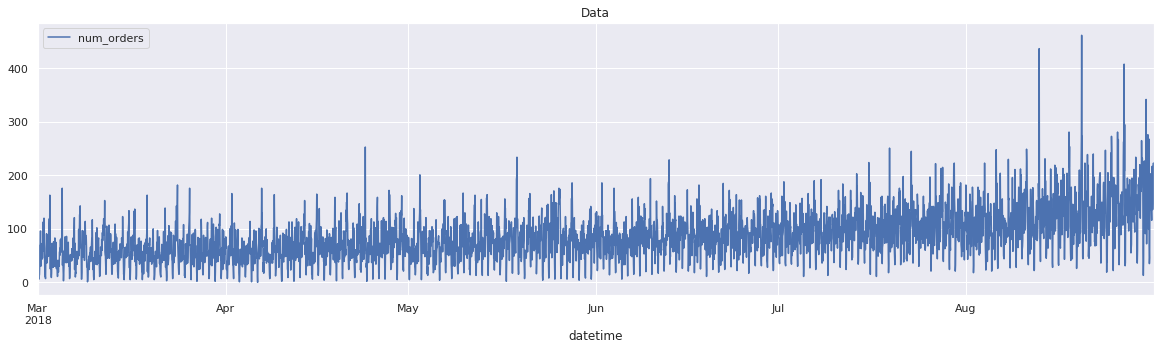

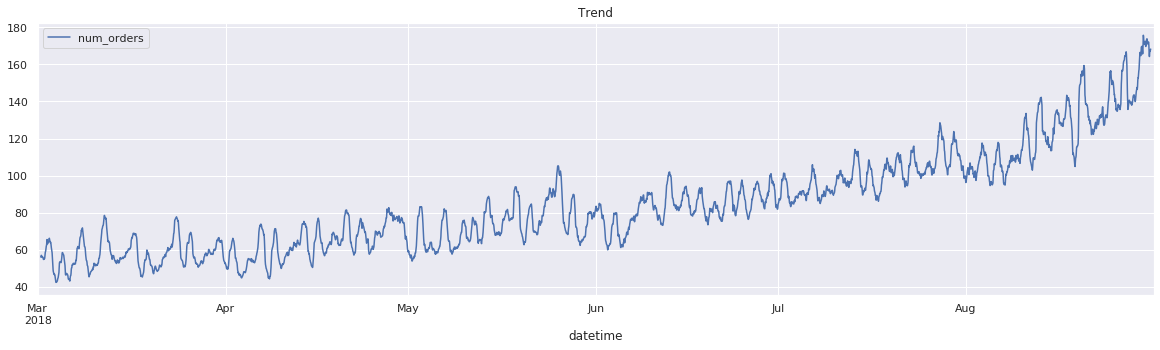

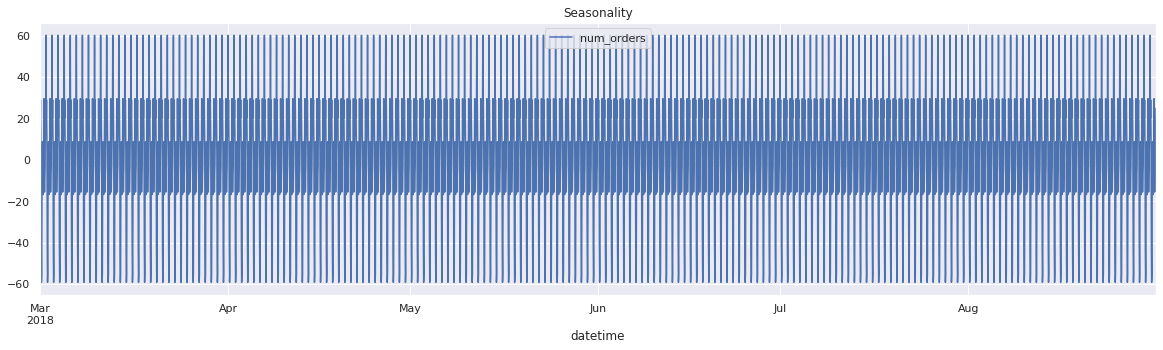

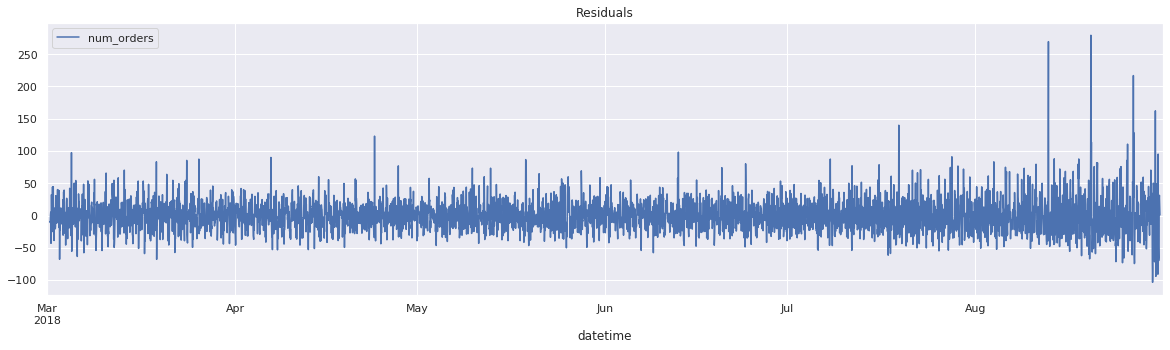

In [6]:
#plot data, trend, seasonality & residuals
decomposed = seasonal_decompose(data)


plt.figure(figsize = (20, 5))
data.plot(ax = plt.gca())
plt.title('Data')
plt.show()

plt.figure(figsize = (20, 5))
decomposed.trend.plot(ax = plt.gca())
plt.title('Trend')
plt.show()

plt.figure(figsize = (20, 5))
decomposed.seasonal.plot(ax = plt.gca())
plt.title('Seasonality')
plt.show()

plt.figure(figsize = (20, 5))
decomposed.resid.plot(ax = plt.gca())
plt.title('Residuals')
plt.show()

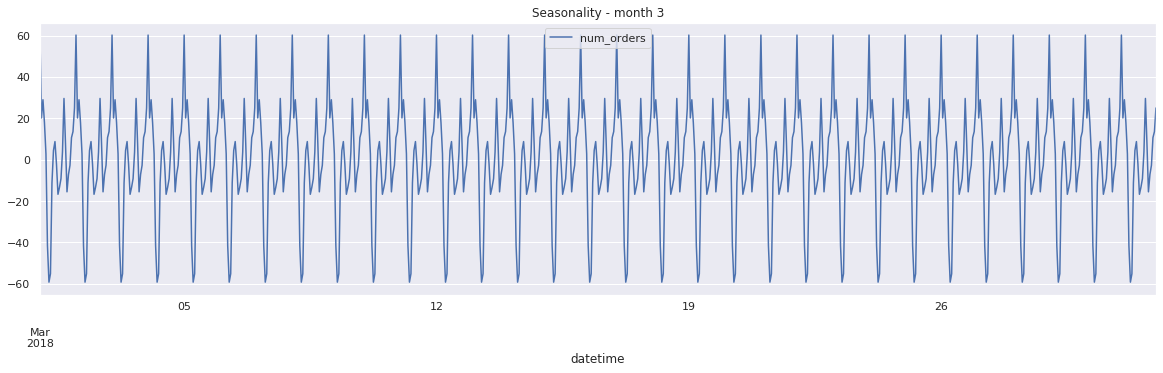

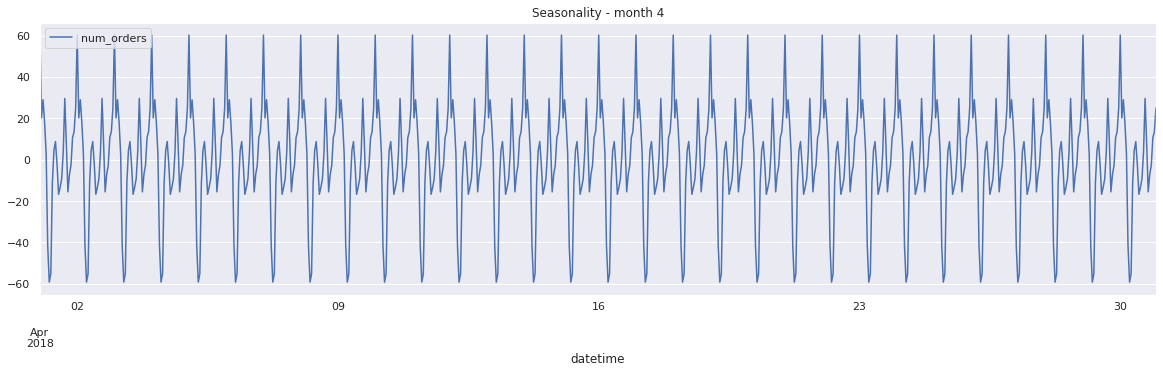

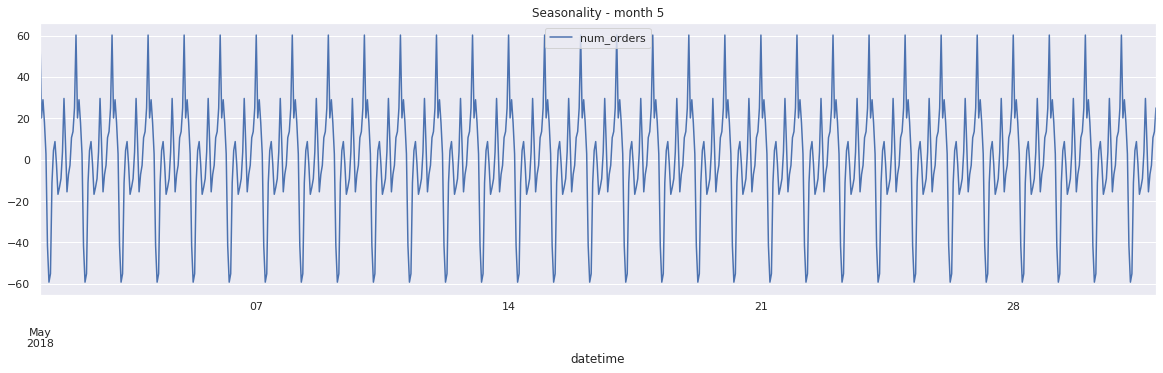

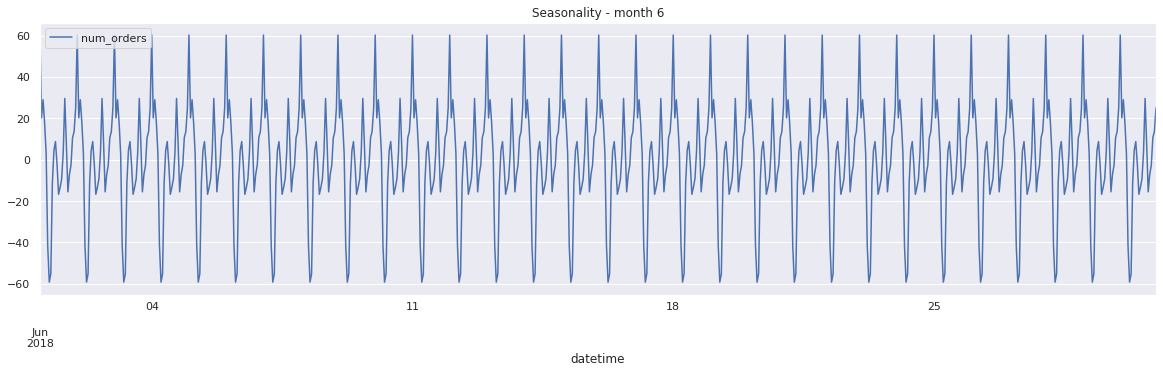

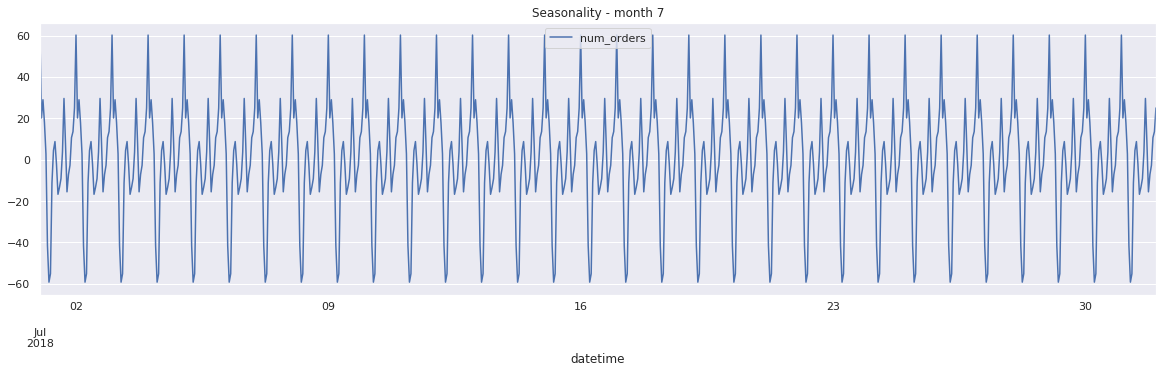

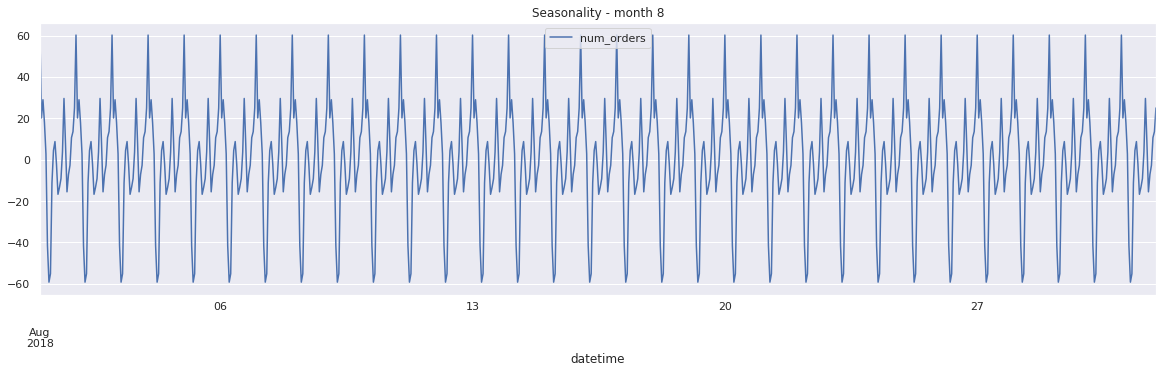

In [7]:
#calculate seasonality by a month
for month in range(3,9):
    plt.figure(figsize=(20, 5))
    decomposed.seasonal[decomposed.seasonal.index.month == month].plot(ax=plt.gca())
    plt.title('Seasonality - month {}'.format(month))
    plt.show()

There is an upward trend and intraday seasonality 

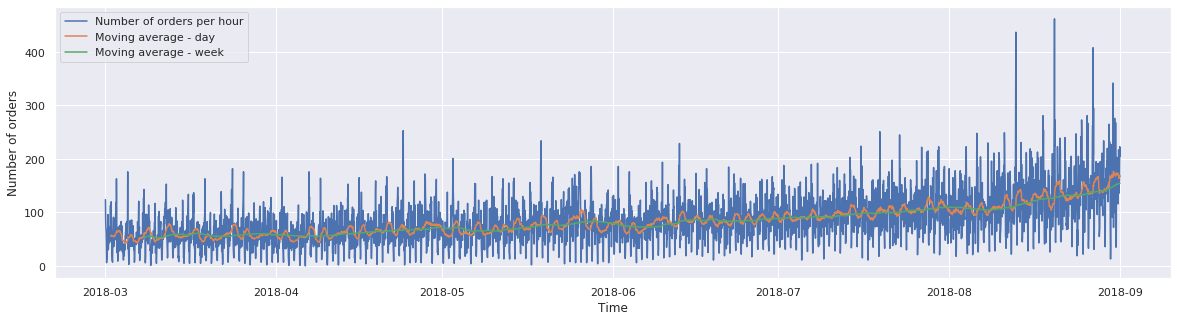

In [8]:
#calculate moving average with 24-hour window
data['moving_average_day'] = data['num_orders'].shift().rolling(24).mean()
data['moving_average_week'] = data['num_orders'].shift().rolling(24*7).mean()

register_matplotlib_converters()
plt.figure(figsize=(20, 5))
sns.lineplot(x = data.index, y = data['num_orders'])
sns.lineplot(x = data.index, y = data['moving_average_day'])
sns.lineplot(x = data.index, y = data['moving_average_week'])
plt.xlabel('Time')
plt.ylabel('Number of orders')
plt.legend(['Number of orders per hour', 'Moving average - day', 'Moving average - week'])
plt.show()

There is an upward, and intraday & intraweek seasonality 

That's why we need to add new features - weekday and hour

In [9]:
#create new variables - weekday, hour
data['weekday'] = data.index.weekday
data['hour'] = data.index.hour

In [10]:
#create new variables with shifts
def df_shift(df, shifts):
    for shift in range(1, shifts+1):
        df['num_orders_{}'.format(shift)] = df['num_orders'].shift(shift)
        
df_shift(data, 24)
data.head()

,num_orders,moving_average_day,moving_average_week,weekday,hour,num_orders_1,num_orders_2,num_orders_3,num_orders_4,num_orders_5,...,num_orders_15,num_orders_16,num_orders_17,num_orders_18,num_orders_19,num_orders_20,num_orders_21,num_orders_22,num_orders_23,num_orders_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#drop empty values
data = data.dropna(axis = 0)

<h2><a id="step_3" style="color: black; text-decoration: none;">3. Modelling</a></h2>

Before building a model we need to extract features and target (number of orders) and then split dataset to train (90%) and test (10%) 

In [12]:
#extract features & target
features = data.copy().drop('num_orders', axis = 1)
target = data['num_orders'].copy()

In [13]:
#split data to train & test samples without shuffling
features_train, features_test, target_train, target_test = \
train_test_split(features, target, random_state = 12345, shuffle = False, test_size = 0.1)

print('Size of train dataset - features:', features_train.shape)
print('Size of train dataset - target:', target_train.shape)
print('Size of test dataset - features:', features_test.shape)
print('Size of test dataset - target:', target_test.shape)

Size of train dataset - features: (3823, 28)
Size of train dataset - target: (3823,)
Size of test dataset - features: (425, 28)
Size of test dataset - target: (425,)


Make a quality metric - RMSE

In [14]:
#make MSE scorer
mse = make_scorer(mean_squared_error)

We are going to cross-validate 3 models:
- linear regression
- random forest
- gradient boosting

For cross-validation we need to split time series to 8 splits:
- 1/(8+ 1) * 90% = 10% (sizes of train & test samples)

In [15]:
#8 splits
tscv = TimeSeriesSplit(n_splits = 8)

<h3><a id="substep_1" style="color: black; text-decoration: none;">3.1. Linear model</a></h3>

In [16]:
#linear model
linear_mse = cross_val_score(LinearRegression(), features_train, target_train, cv = tscv, \
                             scoring = mse).mean()  
print('RMSE of Linear model:', linear_mse ** 0.5)

RMSE of Linear model: 27.224562624403944


<h3><a id="substep_2" style="color: black; text-decoration: none;">3.2. Random forest</a></h3>

In [17]:
#find optimal hyperparameters
forest_score = 1000000000000000
best_estimators = 0

for estimator in range(10, 50):
    forest_mse = cross_val_score(RandomForestRegressor(n_estimators = estimator, \
                                                       random_state = 12345), \
                                 features_train, target_train, cv = tscv, scoring = mse).mean()
    if forest_mse < forest_score:
        forest_score = forest_mse
        best_estimators = estimator


forest_score = 1000000000000000
best_depth = 0

for depth in range(1,20):
    forest_mse = cross_val_score(RandomForestRegressor(max_depth = depth, \
                                                       n_estimators = best_estimators, \
                                         random_state = 12345), features_train, target_train, \
                                 cv = tscv, scoring = mse).mean()
    if forest_mse < forest_score:
        forest_score = forest_mse
        best_depth = depth

                
print('RMSE of Random Forest:', forest_score ** 0.5)
print('Best max depth:', best_depth)
print('Best number of estimators:', best_estimators)

RMSE of Random Forest: 25.047825089383306
Best max depth: 15
Best number of estimators: 49


<h3><a id="substep_3" style="color: black; text-decoration: none;">3.3. Gradient boosting</a></h3>

In [18]:
#find optimal hyperparameters
gbm_score = 1000000000000000
best_leaves = 0

for leaves in range(2, 50, 10):
    gbm_mse = cross_val_score(LGBMRegressor(num_leaves = leaves), features_train, \
                              target_train, cv = tscv, scoring = mse).mean()
    if gbm_mse < gbm_score:
        gbm_score = gbm_mse
        best_leaves = leaves

        
gbm_score = 1000000000000000
best_learning_rate_gbm = 0

for rate in np.linspace(0.01, 0.2, 50):
    gbm_mse = cross_val_score(LGBMRegressor(num_leaves = best_leaves, learning_rate = rate), \
                              features_train, target_train, cv = tscv, scoring = mse).mean()
    if gbm_mse < gbm_score:
        gbm_score = gbm_mse
        best_learning_rate_gbm = rate


print('RMSE of Gradient boosting:', gbm_score ** 0.5)
print('Best number of leaves:', best_leaves)
print('Best learning rate:', best_learning_rate_gbm)   

RMSE of Gradient boosting: 24.75599963042396
Best number of leaves: 32
Best learning rate: 0.048775510204081635


<h3><a id="substep_4" style="color: black; text-decoration: none;">3.4. Model testing</a></h3>

After cross-validation we can models and find if they give a better metric than contant models (simple mean & previous values)

In [19]:
#test linear model
linear_model = LinearRegression()
linear_model.fit(features_train, target_train)
linear_predictions = linear_model.predict(features_test)
linear_test = mean_squared_error(linear_predictions, target_test) ** 0.5
print('RMSE on test data - Linear regression:', linear_test)

RMSE on test data - Linear regression: 44.24503115858897


In [20]:
#test forest model
forest_model = RandomForestRegressor(random_state = 12345, max_depth = best_depth, \
                                      n_estimators = best_estimators)
forest_model.fit(features_train, target_train)
forest_predictions = forest_model.predict(features_test)
forest_test = mean_squared_error(forest_predictions, target_test) ** 0.5
print('RMSE on test data - Random forest:', forest_test)

RMSE on test data - Random forest: 44.73858108456742


In [21]:
#test gbm model
gradient_model = LGBMRegressor(num_leaves = leaves, learning_rate = best_learning_rate_gbm)
gradient_model.fit(features_train, target_train)
gradient_predictions = gradient_model.predict(features_test)
gbm_test = mean_squared_error(gradient_predictions, target_test) ** 0.5
print('RMSE on test data - Gradient boosting:', gbm_test)

RMSE on test data - Gradient boosting: 41.88458208605935


In [22]:
#constant models
mean_predictions = [target.mean() for x in range(len(target_test))]
mean_test = mean_squared_error(mean_predictions, target_test) ** 0.5
print('RMSE on test data - mean constant model', mean_test)

prev_predictions = target_test.copy().shift()
prev_predictions.iloc[0] = target_train.iloc[-1]
prev_test = mean_squared_error(prev_predictions, target_test) ** 0.5
print('RMSE on test data - previous constant model:', prev_test)

RMSE on test data - mean constant model 80.22250761199068
RMSE on test data - previous constant model: 58.819724582830204


In [23]:
#aggregate results in table
results = {'Linear regression': [linear_test], \
           'Random forest': [forest_test], \
           'Gradient boosting': [gbm_test], \
           'Mean value': [mean_test], \
           'Previous value': [prev_test]}
pd.DataFrame(data = results, index = ['RMSE'])

,Linear regression,Random forest,Gradient boosting,Mean value,Previous value
RMSE,44.245031,44.738581,41.884582,80.222508,58.819725


The quality of both Random forest and Gradient boosting models is much higher than of constant models and RMSE is less than 48 (target value of the metric).

We can kook closer at prediction versus actual test data to find out the pattern of errors that the models make.

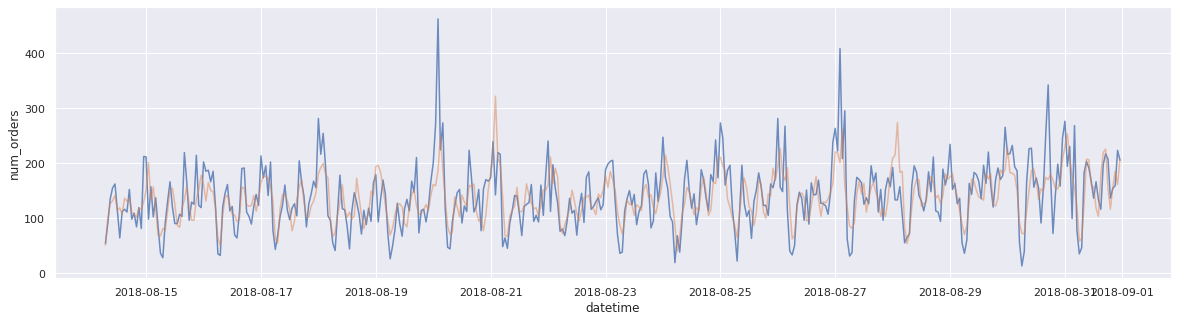

In [24]:
#plot actual and predicted orders - linear model
plt.figure(figsize=(20, 5))
sns.lineplot(x = target_test.index, y = target_test, alpha = 0.8)
sns.lineplot(x = target_test.index, y = linear_predictions, alpha = 0.5)
plt.show()

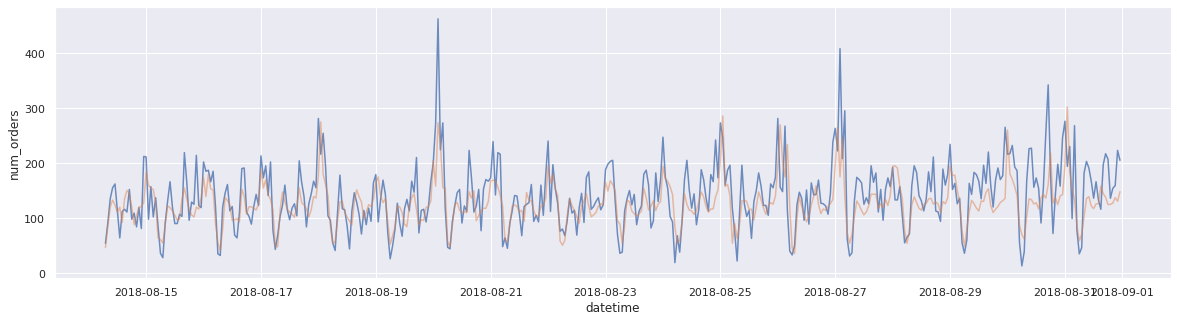

In [25]:
#plot actual and predicted orders - random forest model
plt.figure(figsize=(20, 5))
sns.lineplot(x = target_test.index, y = target_test, alpha = 0.8)
sns.lineplot(x = target_test.index, y = forest_predictions, alpha = 0.5)
plt.show()

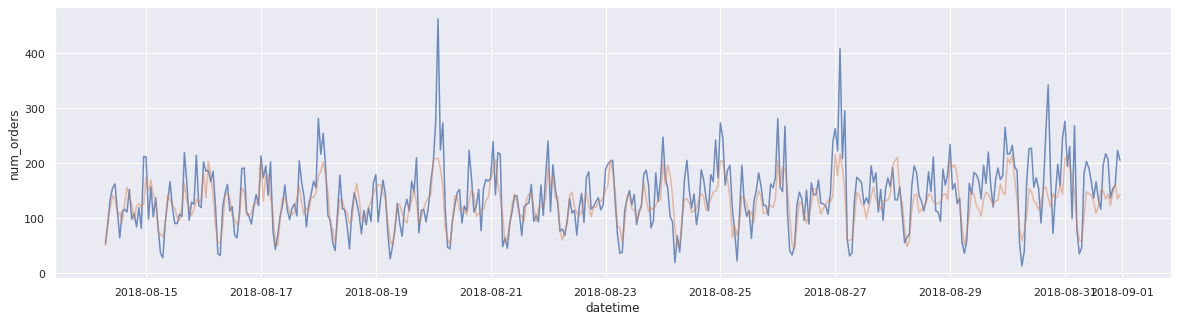

In [26]:
#plot actual and predicted orders - gbm
plt.figure(figsize=(20, 5))
sns.lineplot(x = target_test.index, y = target_test, alpha = 0.8)
sns.lineplot(x = target_test.index, y = gradient_predictions, alpha = 0.5)
plt.show()

Look closer at outliers that are not detected by Gradient boosting model

In [27]:
#reset predictions from Gradient boosting
gradient_predictions = pd.DataFrame(data = {'predictions': gradient_predictions})
gradient_predictions = gradient_predictions.set_index(target_test.index)

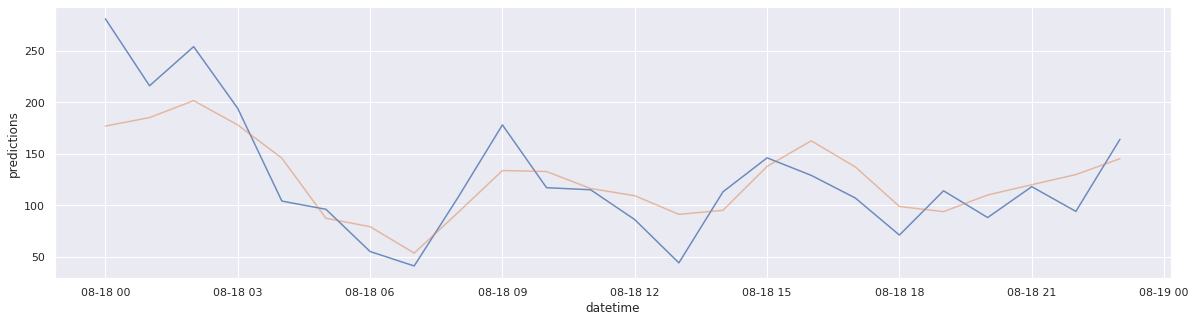

In [28]:
# plot actual and predicted orders for peak at 18.08.2018
plt.figure(figsize=(20, 5))
sns.lineplot(x = target_test['2018-08-18'].index, \
             y = target_test['2018-08-18'], alpha = 0.8)
sns.lineplot(x = target_test['2018-08-18'].index, \
             y = gradient_predictions['2018-08-18']['predictions'], alpha = 0.5)
plt.show()

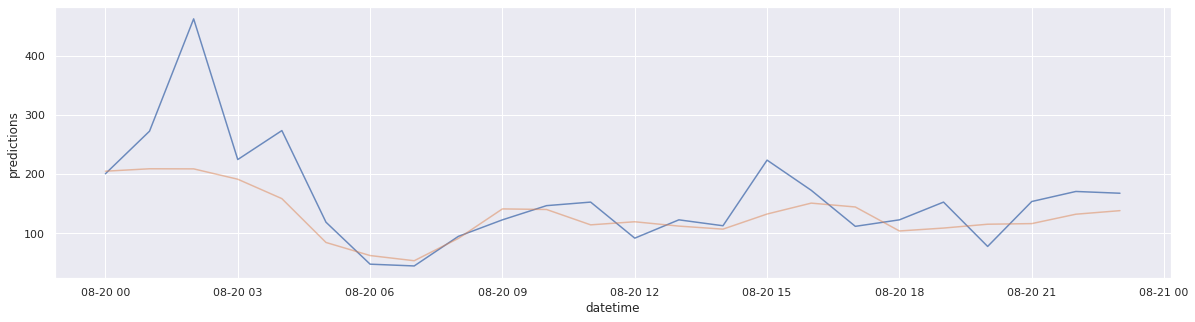

In [29]:
# plot actual and predicted orders for peak at 20.08.2018
plt.figure(figsize=(20, 5))
sns.lineplot(x = target_test['2018-08-20'].index, \
             y = target_test['2018-08-20'], alpha = 0.8)
sns.lineplot(x = target_test['2018-08-20'].index, \
             y = gradient_predictions['2018-08-20']['predictions'], alpha = 0.5)
plt.show()

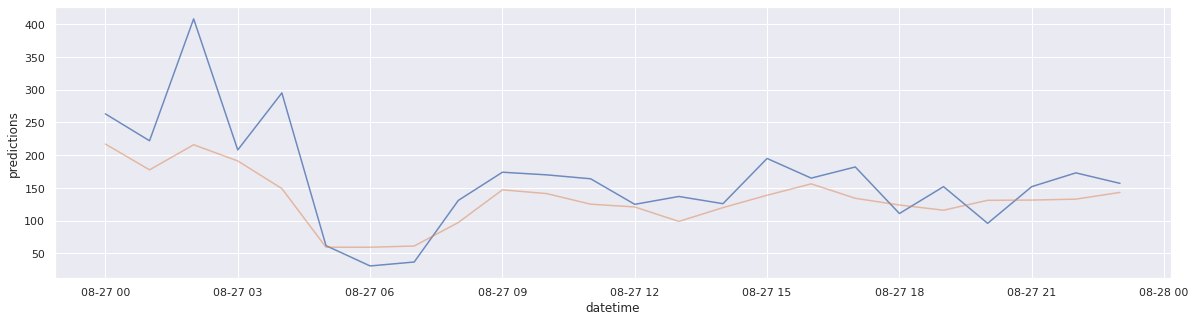

In [30]:
#plot actual and predicted orders for peak at 27.08.2018
plt.figure(figsize=(20, 5))
sns.lineplot(x = target_test['2018-08-27'].index, \
             y = target_test['2018-08-27'], alpha = 0.8)
sns.lineplot(x = target_test['2018-08-27'].index, \
             y = gradient_predictions['2018-08-27']['predictions'], alpha = 0.5)
plt.show()

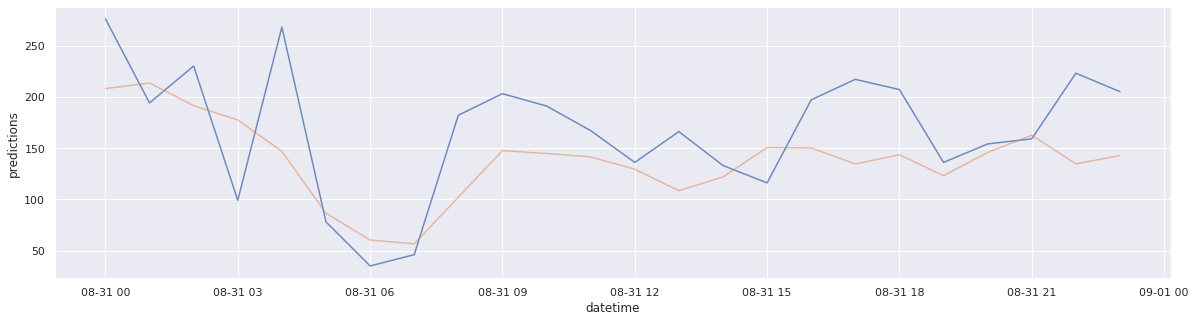

In [31]:
#plot actual and predicted orders for peak at 31.08.2018
plt.figure(figsize=(20, 5))
sns.lineplot(x = target_test['2018-08-31'].index, \
             y = target_test['2018-08-31'], alpha = 0.8)
sns.lineplot(x = target_test['2018-08-31'].index, \
             y = gradient_predictions['2018-08-31']['predictions'], alpha = 0.5)
plt.show()

<h2><a id="step_4" style="color: black; text-decoration: none;">4. Conclusion </a></h2>

On the whole all three models demonstrate comparatively good results on test dataset:
- Best RMSE is 42.5 of gradient boosting model
- Quality of the models exceeds one of constant models (80.4 и 58.9)

Still we see that the models cannot detect the fluctuations that happen in the morning on certain days like some Mondays